<a href="https://colab.research.google.com/github/AwareTeam-LOD/chore/blob/main/chore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте скачаем вначале предоставленные нам данные (датапак), с которым мы и будем работать в дальнейшем. 

> Я загрузил его на свой сервер, чтобы получить прямую ссылку на файл (иначе не получится скачать данные с wget).



In [256]:
!wget https://test.deqstudio.com/datapack.zip -P datas/
!unzip datas/datapack.zip -d datas/

--2022-01-14 11:00:50--  https://test.deqstudio.com/datapack.zip
Resolving test.deqstudio.com (test.deqstudio.com)... 78.46.109.73
Connecting to test.deqstudio.com (test.deqstudio.com)|78.46.109.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2158896 (2.1M) [application/zip]
Saving to: ‘datas/datapack.zip.1’

datapack.zip.1      100%[===================>]   2.06M  2.41MB/s    in 0.9s    

2022-01-14 11:00:51 (2.41 MB/s) - ‘datas/datapack.zip.1’ saved [2158896/2158896]

Archive:  datas/datapack.zip
replace datas/01_all_users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: datas/01_all_users.csv  
replace datas/02_events_log.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: datas/02_events_log.csv  
replace datas/03_lk_events_log.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: datas/03_lk_events_log.csv  
replace datas/04_is_blocked.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: datas/04_is_blocked.csv  
replace datas/te

Давайте установим зависимости и нужные штучки, а так же загрузим датасеты

In [257]:
!pip install pandas numpy keras tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

In [258]:
datas_all_users = pd.read_csv('datas/01_all_users.csv')
datas_events_log = pd.read_csv('datas/02_events_log.csv')
datas_lk_events = pd.read_csv('datas/03_lk_events_log.csv')
datas_is_blocked = pd.read_csv('datas/04_is_blocked.csv')

In [260]:
pd.concat((datas_events_log, datas_is_blocked), axis = 1)
datas_merged = pd.merge(datas_events_log, datas_is_blocked, on=('contract_id'))
datas_merged = pd.merge(datas_merged, datas_lk_events, on=('contract_id'))
datas_merged = pd.merge(datas_merged, datas_all_users, on=('contract_id'))
datas_merged

,contract_id,event_date_x,event_type,blocked,event_date_y,name,day_or_month_contract
0,33846,2021-04-03 19:09:26,Добавление в Обращались с номеров,1,2021-03-19 15:12:52,Информер ВК. Показ,0
1,33846,2021-04-03 19:09:26,Добавление в Обращались с номеров,1,2021-03-27 18:46:04,Информер ВК. Показ,0
2,33846,2021-04-03 19:09:26,Добавление в Обращались с номеров,1,2021-04-03 18:55:22,Информер ВК. Показ,0
3,33846,2021-04-08 10:59:48,Отключение услуги Аренда ТВ-приставки,1,2021-03-19 15:12:52,Информер ВК. Показ,0
4,33846,2021-04-08 10:59:48,Отключение услуги Аренда ТВ-приставки,1,2021-03-27 18:46:04,Информер ВК. Показ,0
...,...,...,...,...,...,...,...
36801,5023,2021-03-19 17:58:07,Манипуляции с оборудованием,0,2021-04-27 21:27:12,Информер ВК. Показ,0
36802,5023,2021-03-19 17:58:07,Манипуляции с оборудованием,0,2021-04-27 21:27:31,Включение IPTV-пакета,0
36803,5023,2021-03-19 17:58:07,Манипуляции с оборудованием,0,2021-04-28 20:26:50,Включение интернета на 20 минут,0
36804,5023,2021-03-19 17:58:07,Манипуляции с оборудованием,0,2021-04-28 20:32:05,Информер ВК. Показ,0


In [261]:
datas_merged = datas_merged.drop(['event_date_x', 'event_date_y', 'contract_id'], axis=1)
datas_merged

,event_type,blocked,name,day_or_month_contract
0,Добавление в Обращались с номеров,1,Информер ВК. Показ,0
1,Добавление в Обращались с номеров,1,Информер ВК. Показ,0
2,Добавление в Обращались с номеров,1,Информер ВК. Показ,0
3,Отключение услуги Аренда ТВ-приставки,1,Информер ВК. Показ,0
4,Отключение услуги Аренда ТВ-приставки,1,Информер ВК. Показ,0
...,...,...,...,...
36801,Манипуляции с оборудованием,0,Информер ВК. Показ,0
36802,Манипуляции с оборудованием,0,Включение IPTV-пакета,0
36803,Манипуляции с оборудованием,0,Включение интернета на 20 минут,0
36804,Манипуляции с оборудованием,0,Информер ВК. Показ,0


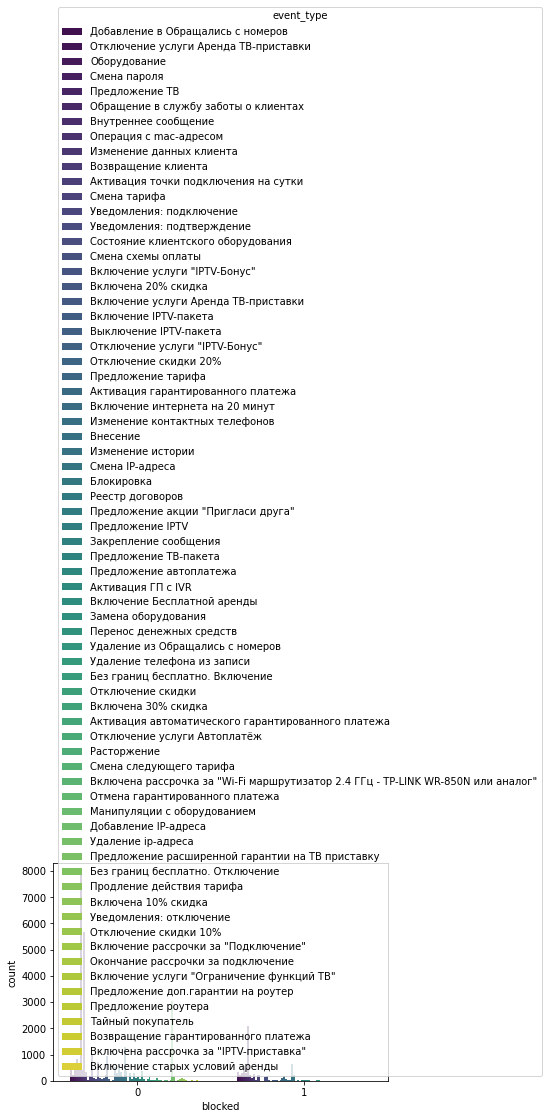

In [262]:
sns.countplot(x='blocked',data=datas_merged, hue='event_type',palette='viridis')

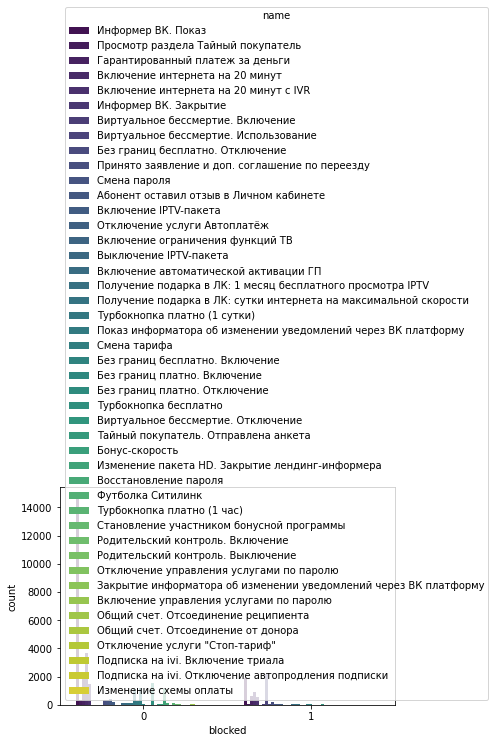

In [263]:
sns.countplot(x='blocked',data=datas_merged, hue='name',palette='viridis')

In [264]:
original_copied = datas_copy = datas_merged
datas_merged_temp = datas_merged
event_type_list = datas_merged.event_type.unique()
exist_events = dict(zip(event_type_list, range(len(event_type_list))))
datas_merged = datas_merged_temp
exist_events

{'Активация ГП с IVR': 37,
 'Активация автоматического гарантированного платежа': 46,
 'Активация гарантированного платежа': 24,
 'Активация точки подключения на сутки': 10,
 'Без границ бесплатно. Включение': 43,
 'Без границ бесплатно. Отключение': 56,
 'Блокировка': 30,
 'Включена 10% скидка': 58,
 'Включена 20% скидка': 17,
 'Включена 30% скидка': 45,
 'Включена рассрочка за "IPTV-приставка"': 68,
 'Включена рассрочка за "Wi-Fi маршрутизатор 2.4 ГГц - TP-LINK WR-850N или аналог"': 50,
 'Включение IPTV-пакета': 19,
 'Включение Бесплатной аренды': 38,
 'Включение интернета на 20 минут': 25,
 'Включение рассрочки за "Подключение"': 61,
 'Включение старых условий аренды': 69,
 'Включение услуги "IPTV-Бонус"': 16,
 'Включение услуги "Ограничение функций ТВ"': 63,
 'Включение услуги Аренда ТВ-приставки': 18,
 'Внесение': 27,
 'Внутреннее сообщение': 6,
 'Возвращение гарантированного платежа': 67,
 'Возвращение клиента': 9,
 'Выключение IPTV-пакета': 20,
 'Добавление IP-адреса': 53,
 'Доб

In [265]:
original_copied_2 = original_copied
datas_merged_temp = original_copied
name_list = original_copied.name.unique()
exist_named = dict(zip(name_list, range(len(name_list)+1)))
datas_merged = datas_merged_temp
exist_named

{'Абонент оставил отзыв в Личном кабинете': 11,
 'Без границ бесплатно. Включение': 22,
 'Без границ бесплатно. Отключение': 8,
 'Без границ платно. Включение': 23,
 'Без границ платно. Отключение': 24,
 'Бонус-скорость': 28,
 'Виртуальное бессмертие. Включение': 6,
 'Виртуальное бессмертие. Использование': 7,
 'Виртуальное бессмертие. Отключение': 26,
 'Включение IPTV-пакета': 12,
 'Включение автоматической активации ГП': 16,
 'Включение интернета на 20 минут': 3,
 'Включение интернета на 20 минут с IVR': 4,
 'Включение ограничения функций ТВ': 14,
 'Включение управления услугами по паролю': 38,
 'Восстановление пароля': 30,
 'Выключение IPTV-пакета': 15,
 'Гарантированный платеж за деньги': 2,
 'Закрытие информатора об изменении уведомлений через ВК платформу': 37,
 'Изменение пакета HD. Закрытие лендинг-информера': 29,
 'Изменение схемы оплаты': 44,
 'Информер ВК. Закрытие': 5,
 'Информер ВК. Показ': 0,
 'Общий счет. Отсоединение от донора': 40,
 'Общий счет. Отсоединение реципиента

In [266]:
datas_copy['event_type'] = datas_copy['event_type'].map(exist_events)
datas_copy['name'] = datas_copy['name'].map(exist_named)
datas_copy

,event_type,blocked,name,day_or_month_contract
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,1,1,0,0
4,1,1,0,0
...,...,...,...,...
36801,52,0,0,0
36802,52,0,12,0
36803,52,0,3,0
36804,52,0,0,0


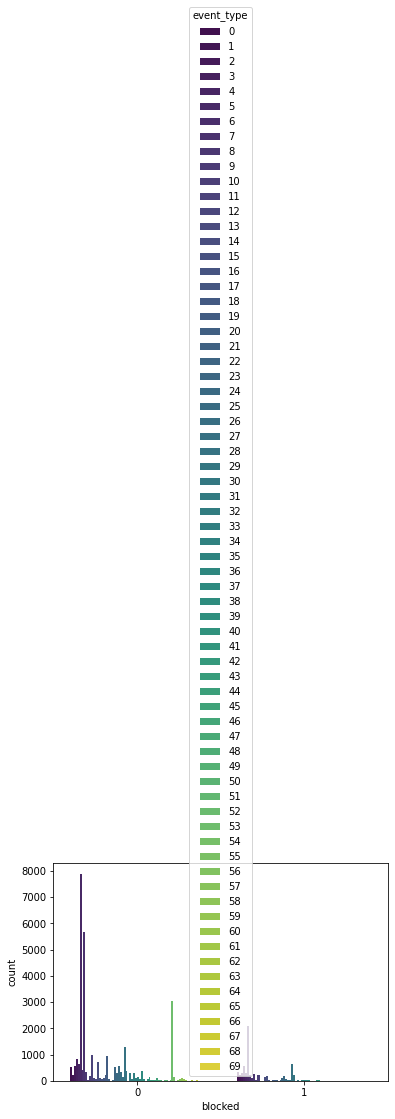

In [267]:
sns.countplot(x='blocked',data=datas_copy, hue='event_type',palette='viridis')

In [279]:
df_train = datas_copy.sample(frac=0.75, random_state=0)
df_test = datas_copy.drop(df_train.index)

selected_features = ['event_type', 'name', 'day_or_month_contract']
#selected_features = ['name', 'day_or_month_contract']

targetName = "blocked"

x_train = df_train[selected_features].values
y_train = df_train[targetName].values.ravel()

In [280]:
#необходимые импорты для части с обучением
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#обучаем дерево выборочной модели
tree_clf = tree.DecisionTreeClassifier()
tree_cv_scores = cross_val_score(tree_clf, x_train, y_train, cv=5, scoring='accuracy')

#обучение кросс валидацией, когда модель обучается и тестируется время от времени
print('Decision tree score: {}'.format(np.mean(tree_cv_scores)))

#совмещаем модель с данными для обучения
tree_clf = tree_clf.fit(x_train, y_train)

#Обучаем модель Logistic Regression
log_reg = LogisticRegression(solver='saga', penalty = 'l2')
logreg_cv_scores = cross_val_score(log_reg, x_train, y_train, cv = 5, scoring = 'accuracy')
#обучение кросс валидацией, когда модель обучается и тестируется время от времени
print('logistic regression score: {}'.format(np.mean(logreg_cv_scores)))

#метрика ROC AUC
rocauc_scores = cross_val_score(log_reg, x_train, y_train, cv = 5, scoring = 'roc_auc')
print('ROC AUC score: {}'.format(np.mean(rocauc_scores)))

#совмещаем модель с данными для обучения
log_reg = log_reg.fit(x_train, y_train)

Decision tree score: 0.8776628498827929
logistic regression score: 0.8111505608362274
ROC AUC score: 0.5832805322358611


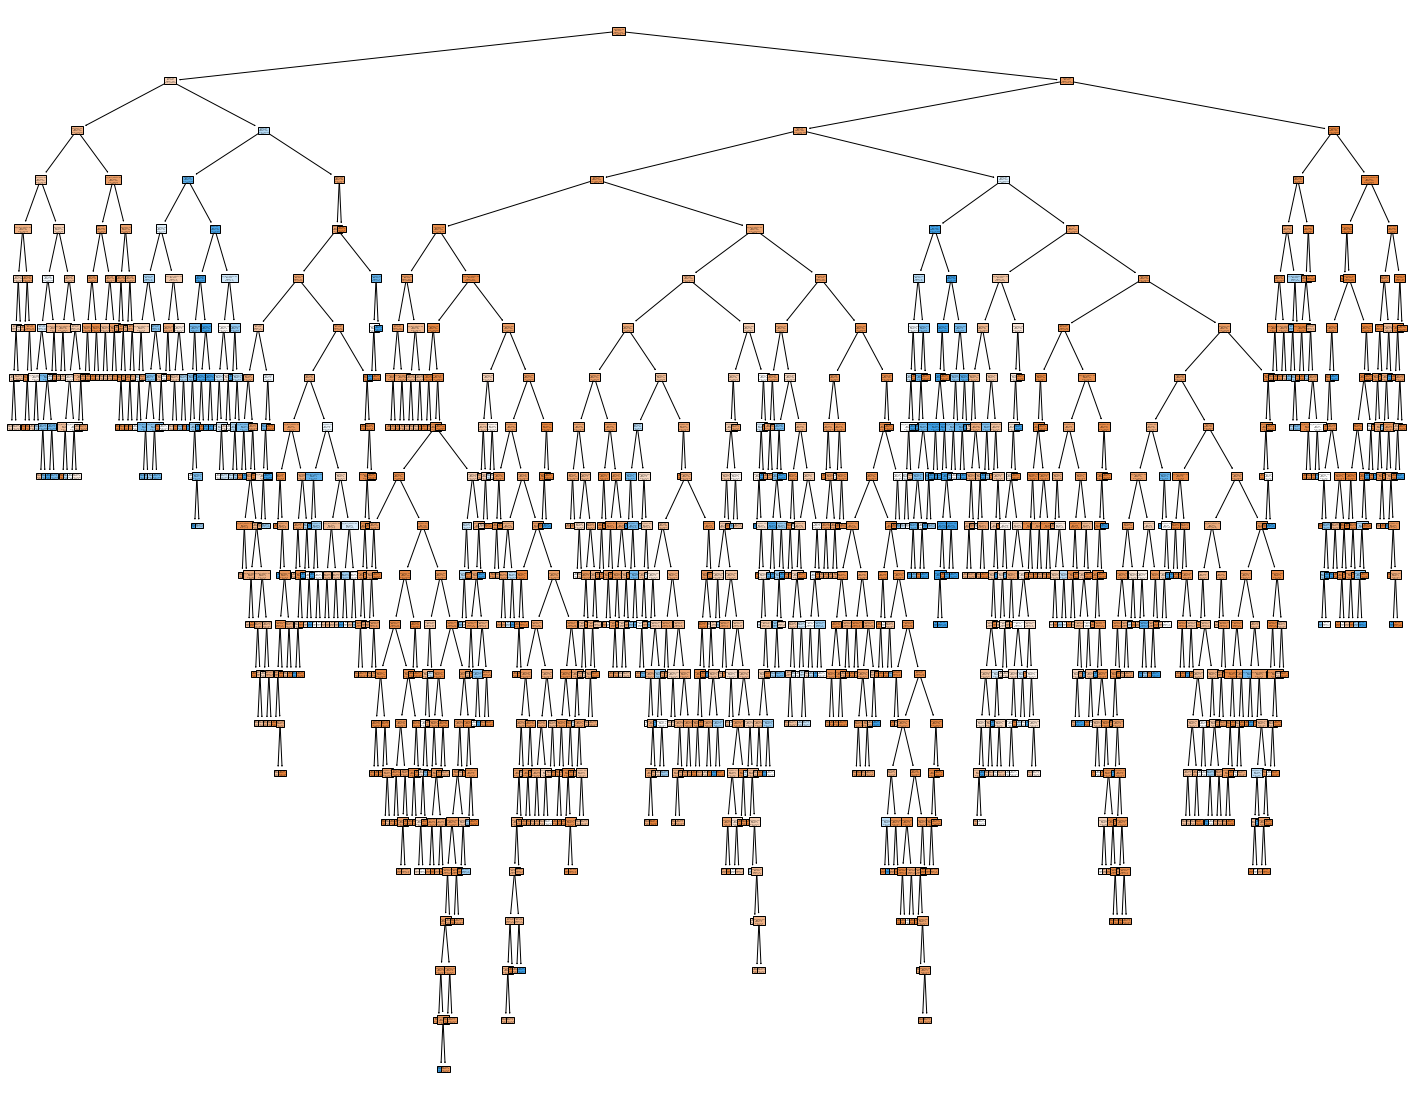

In [270]:
fig = plt.figure(figsize = (25, 20))

_= tree.plot_tree(tree_clf, feature_names=selected_features, class_names = targetName, filled=True)

Тестирование модели, предсказания

In [275]:
#нормализация переменных

from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()
x_train = mm_scaler.fit_transform(x_train)

In [288]:
x_test = df_test[selected_features].values
y_test = df_test[targetName].values.ravel()
x_test_temp = x_test
x_test = mm_scaler.fit_transform(x_test)
# - применили те же методы к тестовым данным, как и к данным для обучения

y_pred = tree_clf.predict(x_test) #наши предсказания
#проверяем, оказались ли предсказания точным
print('Decision tree model accuracy: ', metrics.accuracy_score(y_test, y_pred))

y_pred = log_reg.predict(x_test) #наши предсказания
#проверяем, оказались ли предсказания точным
print('Logistic regression model accuracy: '), metrics.accuracy_score(y_test, y_pred)

#метрика ROC AUC
lr_probs = log_reg.predict(x_test)
lr_probs = lr_probs[:, 1]
print('ROC AUC score: '), roc_auc_score(testy, lr_probs)

#log_reg.predict(X)



Decision tree model accuracy:  0.7925450988915453
Logistic regression model accuracy: 


IndexError: ignored

In [236]:
#datas_merged.loc[df['column_name'] == some_value]
example = [[5]]
print(log_reg.predict(example))

[0]


LogisticRegression: ROC AUC=0.628


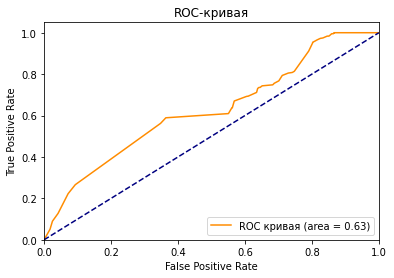

In [316]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

selected_features = ['event_type']
#selected_features = ['name', 'day_or_month_contract']

targetName = "blocked"

# генерируем датасет на 2 класса
df_train = datas_copy.sample(frac=0.85, random_state=0)
df_test = datas_copy.drop(df_train.index)

# разделяем его на 2 выборки
x_train = df_train[selected_features].values
y_train = df_train[targetName].values.ravel()

x_test = df_test[selected_features].values
y_test = df_test[targetName].values.ravel()
x_test_temp = x_test
x_test = mm_scaler.fit_transform(x_test)
# обучаем модель
model = LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
# получаем предказания
lr_probs = model.predict_proba(x_test)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()
